# Import important shtuff

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [5]:
torch.manual_seed(42)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Load Up the Data

In [7]:
train_data = pd.read_csv('fashion-mnist_train.csv')
test_data = pd.read_csv('fashion-mnist_test.csv')

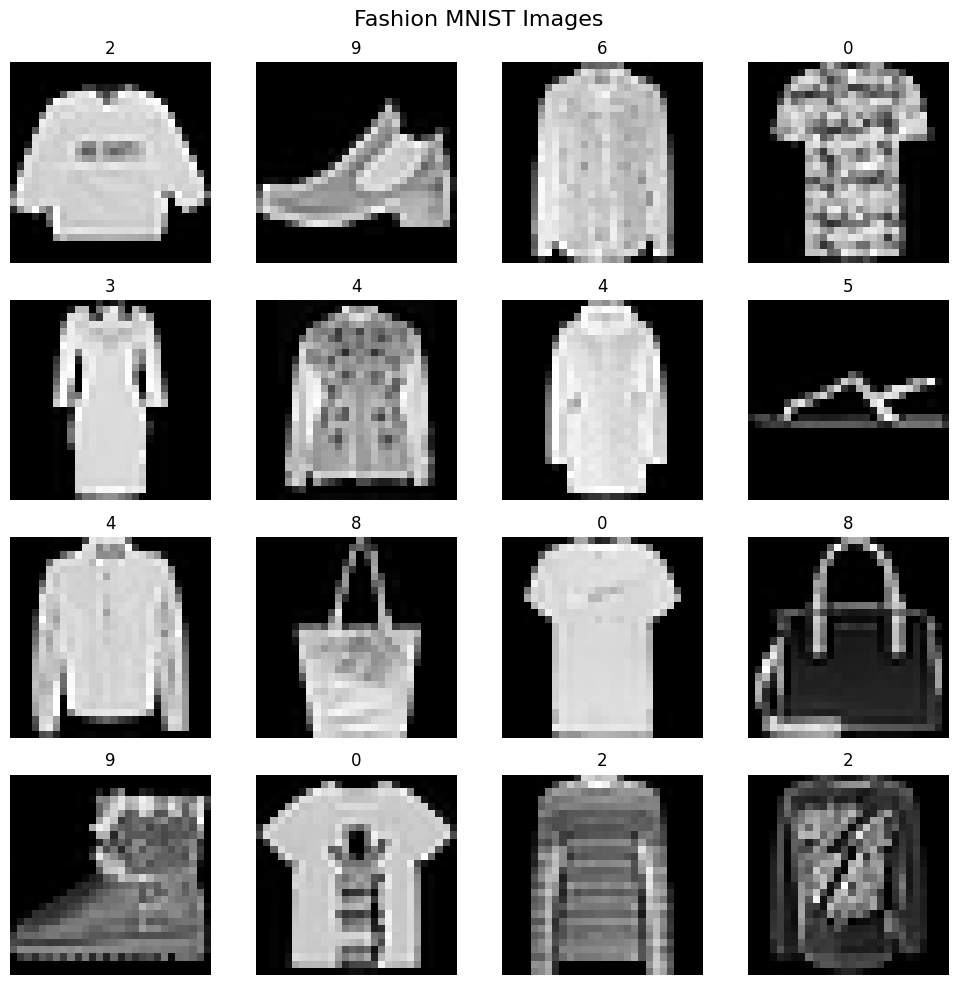

In [8]:
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle('Fashion MNIST Images', fontsize=16)

for i, ax in enumerate(axs.flat):
    img = train_data.iloc[i, 1:].values.reshape(28, 28)
    ax.imshow(img, cmap='grey')
    ax.axis('off')
    ax.set_title(train_data.iloc[i, 0])

plt.tight_layout()
plt.show()

In [9]:
# seperate data and labels
X_train = train_data.iloc[:, 1:].values
y_train = train_data.iloc[:, 0].values

X_test = test_data.iloc[:, 1:].values
y_test = test_data.iloc[:, 0].values

In [10]:
# normalize the values
X_train = X_train / 255.0
X_test = X_test / 255.0

In [11]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        return self.features[index], self.labels[index]

In [12]:
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

In [13]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [33]:
class MyNN(nn.Module):
    def __init__(self, input_dim, output_dim, num_hidden_layers, neurons_per_layer):
        super().__init__()

        layers = []
        for i in range(num_hidden_layers):
            layers.append(nn.Linear(input_dim, neurons_per_layer))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(p=0.3))
            input_dim = neurons_per_layer
        layers.append(nn.Linear(neurons_per_layer, output_dim))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [34]:
def objective(trial):
    # next hyperparam values from search-space
    num_hidden_layers = trial.suggest_int('num_hidden_layers', 1, 4)
    neurons_per_layer = trial.suggest_int('neurons_per_layer', 8, 128, step=8)

    ## other hyperparams that can be found
    # epochs = trial.suggest_int('epochs', 10, 50, step=10)
    # learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    # dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5, step=0.1)
    # batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    # optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])
    # weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-1, log=True)

    ## if batch_size is a hyperparameter for trial
    # train_dataset = CustomDataset(X_train, y_train)
    # test_dataset = CustomDataset(X_test, y_test)

    # initialize model
    input_dim = 784
    output_dim = 10

    model = MyNN(input_dim, output_dim, num_hidden_layers, neurons_per_layer)
    model = model.to(device)

    # initialize params
    learning_rate = 0.001
    epochs = 50

    ## if optimizer is a hyperparameter for trial
    # if optimizer_name == 'Adam':
    #     optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    # elif optimizer_name == 'SGD':
    #     optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay)
    # else:
    #     optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # select optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

    # training loop
    for epoch in range(epochs):
        for batch_features, batch_labels in train_loader:
            # cuda-fy tensors
            batch_features = batch_features.to(device)
            batch_labels = batch_labels.to(device)

            # forward pass
            outputs = model(batch_features)

            # calculate loss
            loss = criterion(outputs, batch_labels)

            # backprop
            optimizer.zero_grad()
            loss.backward()

            # update grads
            optimizer.step()

    # evaluation
    model.eval()

    total = 0
    correct = 0

    with torch.no_grad():
        for batch_features, batch_labels in test_loader:
            batch_features = batch_features.to(device)
            batch_labels = batch_labels.to(device)

            outputs = model(batch_features)
            _, predicted = torch.max(outputs, 1)

            total += batch_labels.shape[0]
            correct += (predicted == batch_labels).sum().item()

    accuracy = correct / total

    return accuracy

In [35]:
# !pip install optuna  #install optuna if not installed

In [36]:
import optuna

study = optuna.create_study(direction='maximize')

[I 2025-05-02 07:35:18,958] A new study created in memory with name: no-name-591e53fd-8b6b-4a02-8a59-b7a12403b680


In [37]:
study.optimize(objective, n_trials=10)

[I 2025-05-02 07:39:33,155] Trial 0 finished with value: 0.8719 and parameters: {'num_hidden_layers': 3, 'neurons_per_layer': 72}. Best is trial 0 with value: 0.8719.
[I 2025-05-02 07:44:08,863] Trial 1 finished with value: 0.7793 and parameters: {'num_hidden_layers': 4, 'neurons_per_layer': 16}. Best is trial 0 with value: 0.8719.
[I 2025-05-02 07:47:30,635] Trial 2 finished with value: 0.8736 and parameters: {'num_hidden_layers': 1, 'neurons_per_layer': 40}. Best is trial 2 with value: 0.8736.
[I 2025-05-02 07:51:18,581] Trial 3 finished with value: 0.8745 and parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 48}. Best is trial 3 with value: 0.8745.
[I 2025-05-02 07:54:39,704] Trial 4 finished with value: 0.8818 and parameters: {'num_hidden_layers': 1, 'neurons_per_layer': 56}. Best is trial 4 with value: 0.8818.
[I 2025-05-02 07:58:26,958] Trial 5 finished with value: 0.861 and parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 24}. Best is trial 4 with value: 0.8818.

In [38]:
study.best_value

0.8847

In [39]:
study.best_params

{'num_hidden_layers': 1, 'neurons_per_layer': 104}